In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
conn = psycopg2.connect(database='hackathon2020_dev', user="postgres", password="Allo123!", host="127.0.0.1", port="5432")

df = pd.read_sql_query("SELECT * FROM public.trump_tweets",con=conn,index_col=['id'])
df.head()

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at
id,,,,,,,,,,
43298,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241
43299,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241
43300,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241
43301,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241
43302,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241


In [3]:
airline_df = pd.read_csv("../db/Tweets.csv")
airline_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
airline_review_df = airline_df[['text','airline_sentiment']]

airline_review_df = airline_review_df[airline_review_df['airline_sentiment'] != 'neutral']
airline_review_df.head(5)

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [5]:
print(airline_review_df["airline_sentiment"].value_counts())

sentiment_label = airline_review_df.airline_sentiment.factorize()
print(sentiment_label)

tweet = airline_review_df.text.values
print(tweet)

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64
(array([0, 1, 1, ..., 0, 1, 1]), Index(['positive', 'negative'], dtype='object'))
["@VirginAmerica plus you've added commercials to the experience... tacky."
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'
 "@VirginAmerica and it's a really big bad thing about it" ...
 '@AmericanAir thank you we got on a different flight to Chicago.'
 "@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc"
 "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"]


In [6]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [7]:
# Try using a long short-term memory net

vocab_size = 10000
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 336,651
Trainable params: 336,651
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(padded_sequence, sentiment_label[0], validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 33s 106ms/step - loss: 0.4157 - accuracy: 0.8333 - val_loss: 0.2163 - val_accuracy: 0.9160
Epoch 2/5
289/289 [==============================] - 47s 161ms/step - loss: 0.2212 - accuracy: 0.9137 - val_loss: 0.1678 - val_accuracy: 0.9407
Epoch 3/5
289/289 [==============================] - 47s 161ms/step - loss: 0.1643 - accuracy: 0.9385 - val_loss: 0.1606 - val_accuracy: 0.9446
Epoch 4/5
289/289 [==============================] - 61s 211ms/step - loss: 0.1390 - accuracy: 0.9478 - val_loss: 0.1668 - val_accuracy: 0.9428
Epoch 5/5
289/289 [==============================] - 67s 231ms/step - loss: 0.1137 - accuracy: 0.9572 - val_loss: 0.1676 - val_accuracy: 0.9454


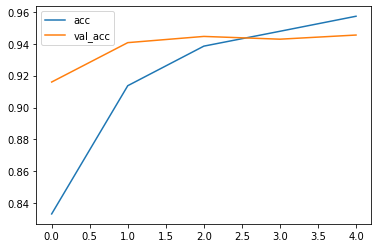

In [9]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

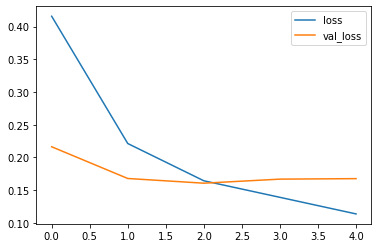

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [11]:
def predict_sentiment(text, model_for_prediction):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen=200)
    return int(model_for_prediction.predict(tw).round().item())

In [12]:
model.save('../notebooks/sentiment_predictor')

INFO:tensorflow:Assets written to: ../notebooks/sentiment_predictor/assets


In [13]:
model = load_model('../notebooks/sentiment_predictor')

In [14]:
predict_sentiment('fucking morons', model)

1

In [15]:
df['sentiment'] = None

def analyze_tweets(target_df, model):
    return [predict_sentiment(x, model) for x in df['content'].array]

#df['sentiment'] = analyze_tweets(df, model)

In [16]:
df.head(5)

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at,sentiment
id,,,,,,,,,,,
43298,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None
43299,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None
43300,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None
43301,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None
43302,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,None


In [26]:
content_array = df['content'].array
df['sentiment'] = [predict_sentiment(x, model) for x in content_array]

In [27]:
df.head(5)

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at,sentiment
id,,,,,,,,,,,
43298,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1
43299,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0
43300,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1
43301,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1
43302,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1


In [41]:
sentiments = df['sentiment'].array
ids = df['tweetId'].array

update_array = list(zip(ids, sentiments))

update_sql = ['update public.trump_tweets set "sentiment" = {} where "tweetId" = {};'.format(row[1], row[0]) for row in update_array]
print(len(update_sql))

43297


In [42]:
with open('../db/update_data/update_sentiment.sql', 'w') as output:
    output.write('\n'.join(update_sql))